# Load Model and Predict on Chest X-ray Image

Load the best_baseline_cnn.h5 model and make predictions on the provided X-ray image.

In [3]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image as img_utils
import matplotlib.pyplot as plt
from PIL import Image

# Model path
model_dir = r'c:\Users\dat\Projects\DA\Pneumonia\pneumonia_baseline_cnn_20251118_091549'
model_path = os.path.join(model_dir, 'best_baseline_cnn.h5')

# Load model
print("Loading model...")
model = keras.models.load_model(model_path)
print("✓ Model loaded successfully!")

# Load model info
info_path = os.path.join(model_dir, 'model_info.json')
with open(info_path, 'r') as f:
    model_info = json.load(f)

print(f"\nModel Info:")
print(f"  - Total params: {model_info['total_params']:,}")
print(f"  - Input shape: {model_info['input_shape']}")
print(f"  - Test Accuracy: {model_info['test_accuracy']:.4f}")
print(f"  - Test AUC: {model_info['test_auc']:.4f}")

Loading model...


✓ Model loaded successfully!

Model Info:
  - Total params: 27,000,801
  - Input shape: [224, 224, 1]
  - Test Accuracy: 0.8574
  - Test AUC: 0.9516


In [29]:
# Function to predict on an image
def predict_xray(image_path):
    """
    Load X-ray image and predict if it shows pneumonia or not
    """
    # Load and preprocess image
    img = img_utils.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Determine class
    if prediction > 0.5:
        predicted_class = 'PNEUMONIA'
        confidence = prediction
    else:
        predicted_class = 'NORMAL'
        confidence = 1 - prediction
    
    return {
        'image': img,
        'prediction': prediction,
        'predicted_class': predicted_class,
        'confidence': confidence
    }

# Predict on the provided X-ray image
image_path = r'c:\Users\dat\Projects\DA\Pneumonia\xray.jpeg'

print(f"\nPredicting on image: {image_path}")
result = predict_xray(image_path)

print(f"\n{'='*50}")
print(f"PREDICTION RESULT")
print(f"{'='*50}")
print(f"Predicted Class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Raw Probability: {result['prediction']:.6f}")
print(f"{'='*50}")


Predicting on image: c:\Users\dat\Projects\DA\Pneumonia\xray.jpeg

PREDICTION RESULT
Predicted Class: NORMAL
Confidence: 99.86%
Raw Probability: 0.001401


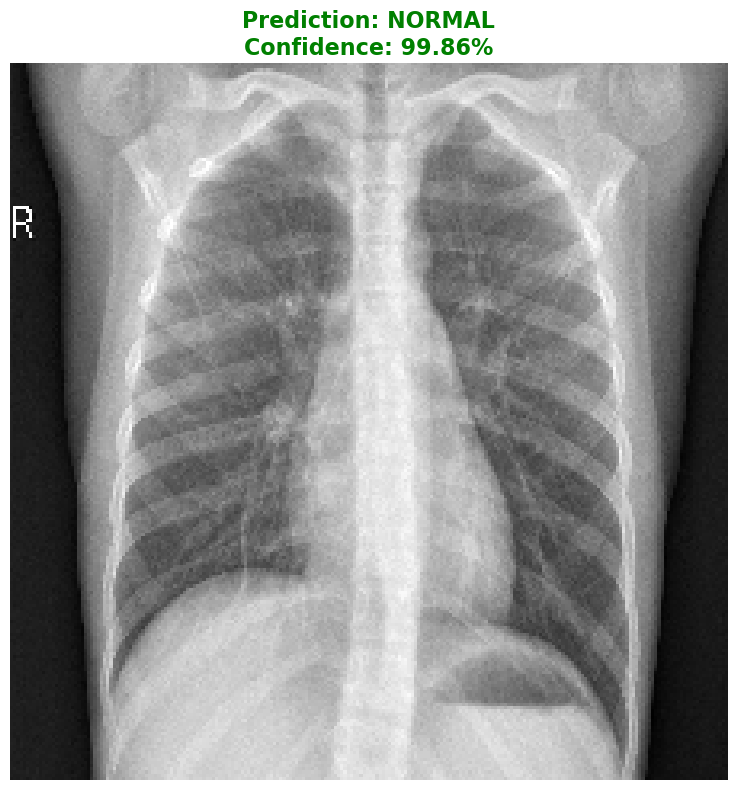

✓ Image displayed successfully!


In [30]:
# Display the image and prediction result
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Display image
ax.imshow(result['image'], cmap='gray')

# Set title with prediction result
title_color = 'red' if result['predicted_class'] == 'PNEUMONIA' else 'green'
title = f"Prediction: {result['predicted_class']}\nConfidence: {result['confidence']:.2%}"
ax.set_title(title, fontsize=16, fontweight='bold', color=title_color)

ax.axis('off')
plt.tight_layout()
plt.show()

print("✓ Image displayed successfully!")

## Grad-CAM Implementation

Gradient-weighted Class Activation Mapping (Grad-CAM) giúp hiển thị vùng mà mô hình tập trung để đưa ra quyết định.

## Phân tích nhiều ảnh Pneumonia với Grad-CAM

Áp dụng Grad-CAM cho nhiều ảnh dương tính để thấy mô hình tập trung vào vùng nào.

✓ Grad-CAM functions defined successfully!
✓ Last convolutional layer: conv2d_7

GENERATING GRAD-CAM VISUALIZATION...
Prediction: NORMAL (99.86%)
Creating Grad-CAM heatmap...
Creating superimposed image...
Creating superimposed image...


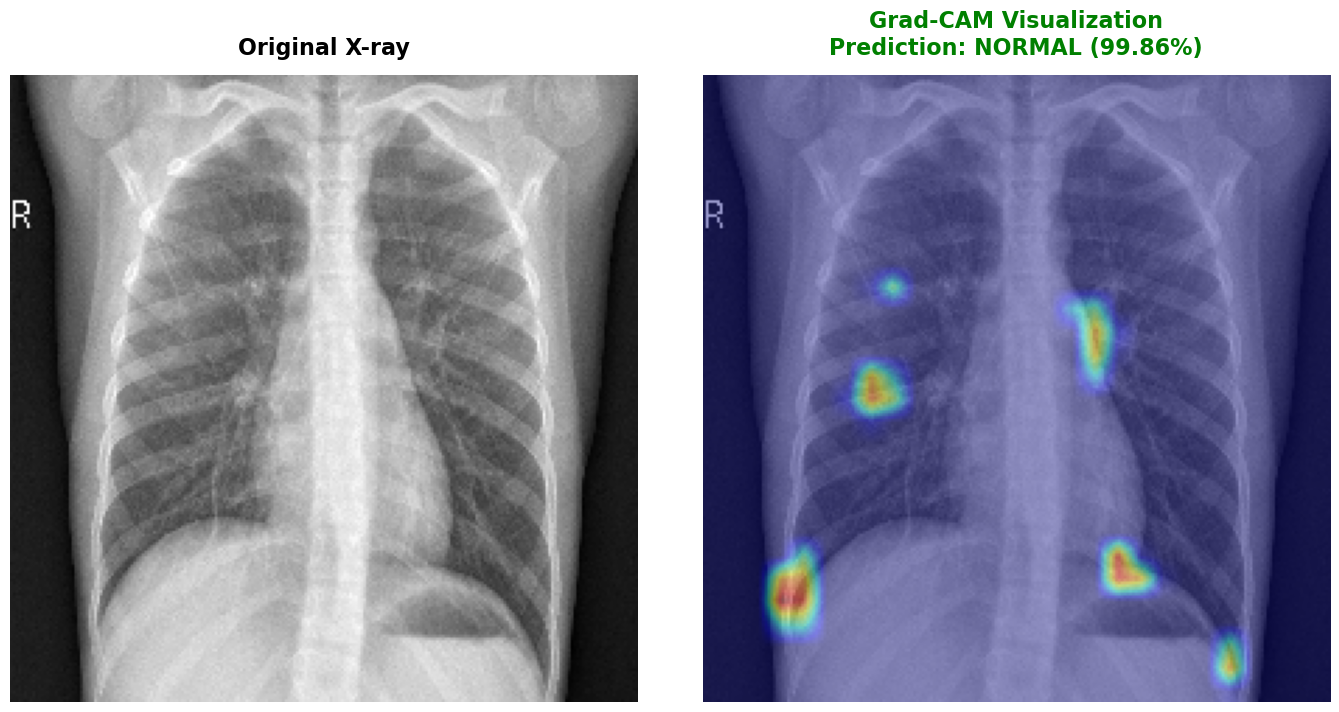


GRAD-CAM ANALYSIS
Predicted Class: NORMAL
Confidence: 99.86%

Grad-CAM highlights the regions that contributed most to
the model's prediction (warmer colors = higher importance)


In [31]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Tạo Grad-CAM heatmap - Không tạo grad_model mới
    """
    # Tạo một function để lấy conv layer output
    conv_layer_model = keras.Model(
        inputs=model.inputs,
        outputs=model.get_layer(last_conv_layer_name).output
    )
    
    # Tính gradient
    with tf.GradientTape() as tape:
        # Forward pass qua conv layer
        conv_outputs = conv_layer_model(img_array)
        tape.watch(conv_outputs)
        
        # Tạo temp model từ conv output đến final output
        # Lấy tất cả layers sau conv layer
        conv_layer_index = None
        for i, layer in enumerate(model.layers):
            if layer.name == last_conv_layer_name:
                conv_layer_index = i
                break
        
        # Forward pass từ conv output đến prediction
        x = conv_outputs
        for layer in model.layers[conv_layer_index + 1:]:
            x = layer(x)
        
        # Lấy class prediction
        if pred_index is None:
            pred_index = tf.argmax(x[0])
        
        class_channel = x[:, pred_index]
    
    # Tính gradient
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weighted combination
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    
    return heatmap.numpy()


def create_superimposed_image(img, heatmap, alpha=0.4):
    """
    Tạo ảnh kết hợp giữa ảnh gốc và heatmap
    """
    # Convert PIL Image to numpy array nếu cần
    if isinstance(img, Image.Image):
        img = np.array(img)
    
    # Resize heatmap về kích thước ảnh gốc
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Chuyển heatmap thành RGB với colormap
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    
    # Convert grayscale to RGB nếu cần
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Normalize ảnh gốc về [0, 255]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    # Kết hợp ảnh
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    
    return superimposed_img


print("✓ Grad-CAM functions defined successfully!")

# Lấy tên conv layer cuối cùng
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"✓ Last convolutional layer: {last_conv_layer_name}")


def visualize_gradcam(image_path, save_path=None):
    """
    Hiển thị Grad-CAM cho ảnh X-ray - CHỈ 2 ẢNH
    """
    # Load và preprocess ảnh
    img = img_utils.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_utils.img_to_array(img) / 255.0
    img_array_input = np.expand_dims(img_array, axis=0)
    
    # Dự đoán
    prediction = model.predict(img_array_input, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    
    print(f"Prediction: {predicted_class} ({confidence:.2%})")
    
    # Tạo Grad-CAM heatmap
    print("Creating Grad-CAM heatmap...")
    heatmap = make_gradcam_heatmap(img_array_input, model, last_conv_layer_name)
    
    # Tạo ảnh kết hợp
    print("Creating superimposed image...")
    superimposed_img = create_superimposed_image(img, heatmap, alpha=0.4)
    
    # Hiển thị kết quả - CHỈ 2 ẢNH
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Ảnh gốc
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original X-ray', fontsize=16, fontweight='bold', pad=15)
    axes[0].axis('off')
    
    # Ảnh Grad-CAM kết hợp
    axes[1].imshow(superimposed_img)
    title_color = 'red' if predicted_class == 'PNEUMONIA' else 'green'
    title = f'Grad-CAM Visualization\nPrediction: {predicted_class} ({confidence:.2%})'
    axes[1].set_title(title, fontsize=16, fontweight='bold', color=title_color, pad=15)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
    
    plt.show()
    
    return {
        'prediction': prediction,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'heatmap': heatmap,
        'superimposed': superimposed_img
    }


# VISUALIZATION
print("\n" + "="*60)
print("GENERATING GRAD-CAM VISUALIZATION...")
print("="*60)

gradcam_result = visualize_gradcam(image_path)

print(f"\n{'='*60}")
print(f"GRAD-CAM ANALYSIS")
print(f"{'='*60}")
print(f"Predicted Class: {gradcam_result['predicted_class']}")
print(f"Confidence: {gradcam_result['confidence']:.2%}")
print(f"\nGrad-CAM highlights the regions that contributed most to")
print(f"the model's prediction (warmer colors = higher importance)")
print(f"{'='*60}")

## So sánh: NORMAL vs PNEUMONIA với Grad-CAM

Hiển thị sự khác biệt trong cách mô hình nhìn các trường hợp Normal và Pneumonia.

Creating detailed Grad-CAM comparison...


C:\Users\dat\AppData\Local\Temp\ipykernel_12268\3901950445.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


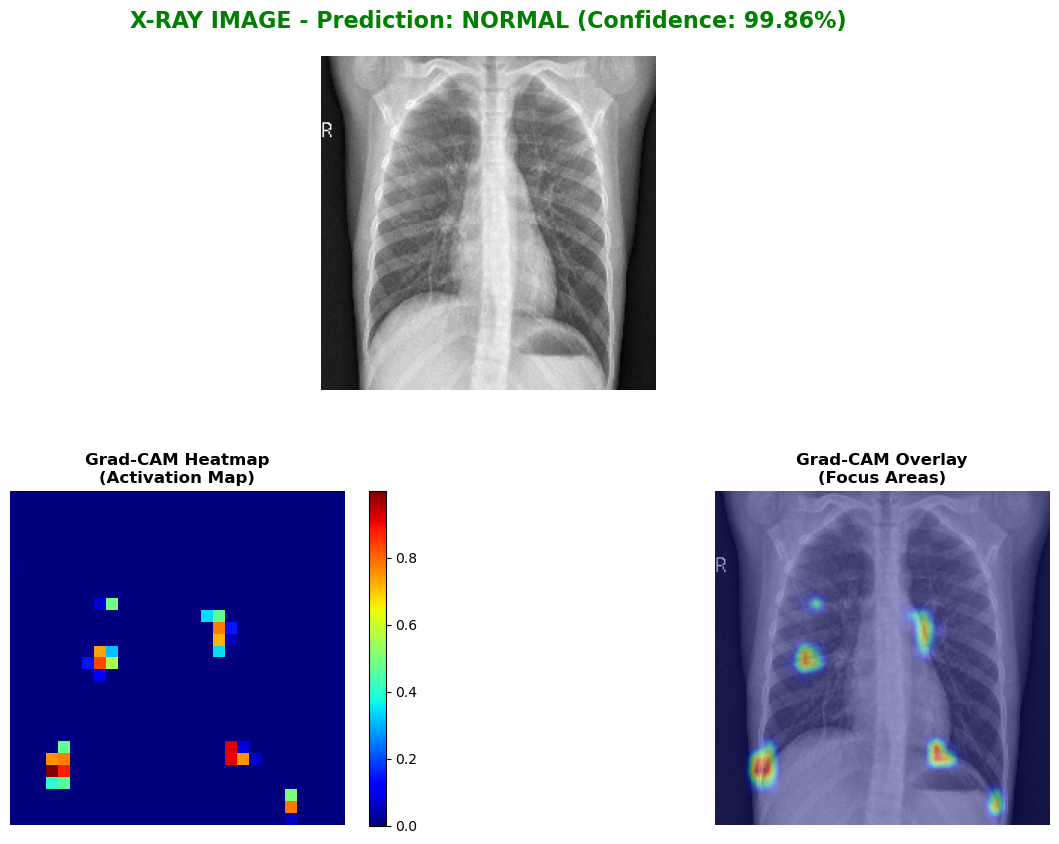

In [33]:
def compare_gradcam(image_path):
  """
  Hiển thị so sánh chi tiết giữa ảnh gốc, heatmap và ảnh kết hợp
  """
  # Load và preprocess ảnh
  img = img_utils.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
  img_array = img_utils.img_to_array(img) / 255.0
  img_array_input = np.expand_dims(img_array, axis=0)
  
  # Dự đoán
  prediction = model.predict(img_array_input, verbose=0)[0][0]
  predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
  confidence = prediction if prediction > 0.5 else (1 - prediction)
  
  # Tạo Grad-CAM heatmap
  heatmap = make_gradcam_heatmap(img_array_input, model, last_conv_layer_name)
  
  # Tạo ảnh kết hợp
  superimposed_img = create_superimposed_image(img, heatmap, alpha=0.4)
  
  # Hiển thị kết quả với layout đẹp hơn
  fig = plt.figure(figsize=(18, 10))
  gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
  
  # Hàng 1: Ảnh gốc
  ax1 = fig.add_subplot(gs[0, :])
  ax1.imshow(img, cmap='gray')
  title_color = 'red' if predicted_class == 'PNEUMONIA' else 'green'
  ax1.set_title(f'X-RAY IMAGE - Prediction: {predicted_class} (Confidence: {confidence:.2%})', 
          fontsize=16, fontweight='bold', color=title_color, pad=20)
  ax1.axis('off')
  
  # Hàng 2: Heatmap và Overlay
  ax2 = fig.add_subplot(gs[1, 0])
  im = ax2.imshow(heatmap, cmap='jet')
  ax2.set_title('Grad-CAM Heatmap\n(Activation Map)', fontsize=12, fontweight='bold')
  ax2.axis('off')
  plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
  
  ax3 = fig.add_subplot(gs[1, 1])
  ax3.imshow(superimposed_img)
  ax3.set_title('Grad-CAM Overlay\n(Focus Areas)', fontsize=12, fontweight='bold')
  ax3.axis('off')
  
  plt.tight_layout()
  plt.show()
  
  return {
    'prediction': prediction,
    'predicted_class': predicted_class,
    'confidence': confidence,
    'heatmap': heatmap,
    'superimposed': superimposed_img
  }

# So sánh chi tiết
print("Creating detailed Grad-CAM comparison...")
detailed_result = compare_gradcam(image_path)


## Hàm tiện ích: Dự đoán và hiển thị Grad-CAM cho ảnh mới

Sử dụng hàm này để nhanh chóng phân tích bất kỳ ảnh X-ray nào.

Analyzing: x-ray-image-2b_full.jpg
------------------------------------------------------------


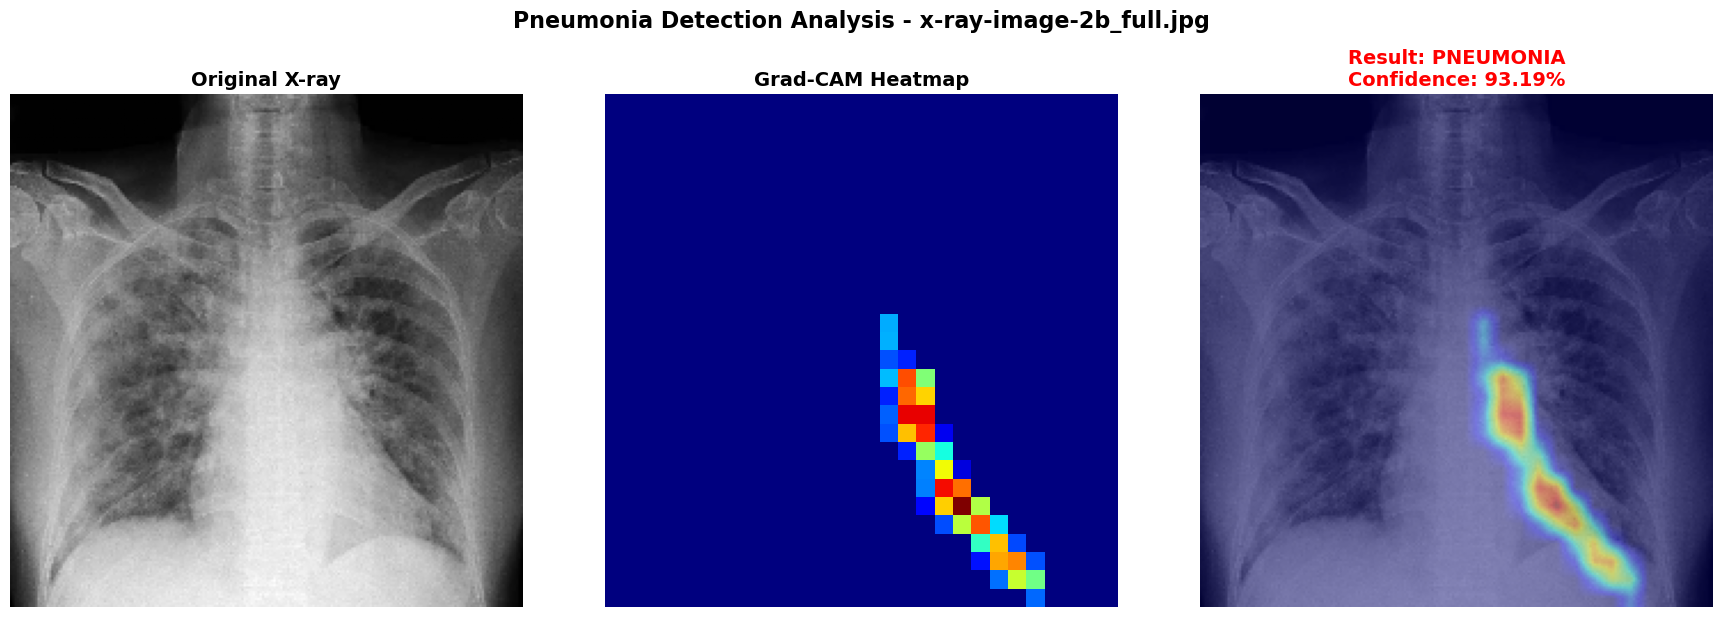


PREDICTION RESULT:
  • Class: PNEUMONIA
  • Confidence: 93.19%
  • Probability: 0.931888



In [36]:
def quick_pneumonia_analysis(image_path, save_result=False):
    """
    Hàm tiện ích để phân tích nhanh ảnh X-ray với Grad-CAM
    
    Args:
        image_path: Đường dẫn đến ảnh X-ray
        save_result: Lưu kết quả ra file hay không
    
    Returns:
        Dictionary chứa kết quả phân tích
    """
    print(f"Analyzing: {os.path.basename(image_path)}")
    print("-" * 60)
    
    # Load và preprocess ảnh
    img = img_utils.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_utils.img_to_array(img) / 255.0
    img_array_input = np.expand_dims(img_array, axis=0)
    
    # Dự đoán
    prediction = model.predict(img_array_input, verbose=0)[0][0]
    predicted_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    
    # Tạo Grad-CAM
    heatmap = make_gradcam_heatmap(img_array_input, model, last_conv_layer_name)
    superimposed_img = create_superimposed_image(img, heatmap, alpha=0.4)
    
    # Hiển thị
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original X-ray', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(superimposed_img)
    title_color = 'red' if predicted_class == 'PNEUMONIA' else 'green'
    axes[2].set_title(f'Result: {predicted_class}\nConfidence: {confidence:.2%}', 
                     fontsize=14, fontweight='bold', color=title_color)
    axes[2].axis('off')
    
    plt.suptitle(f'Pneumonia Detection Analysis - {os.path.basename(image_path)}', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    if save_result:
        save_path = f'gradcam_result_{os.path.basename(image_path)}'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    # In kết quả
    print(f"\n{'='*60}")
    print(f"PREDICTION RESULT:")
    print(f"  • Class: {predicted_class}")
    print(f"  • Confidence: {confidence:.2%}")
    print(f"  • Probability: {prediction:.6f}")
    print(f"{'='*60}\n")
    
    return {
        'image_path': image_path,
        'prediction': prediction,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'heatmap': heatmap,
        'visualization': superimposed_img
    }

# Ví dụ sử dụng
result = quick_pneumonia_analysis('./images/x-ray-image-2b_full.jpg', save_result=False)